# Apply Data Storytelling

The following submission uses data scraped from the website of my employer, the Mercatus Center, a university-based research center. The data is in the form of research output, which includes research papers, research briefs, opinion editorials, public interest comments, and other short-form output.

Unfortunately, actually getting the reader the data would be extremely cumbersome, as it is several gigabytes large. However, my experience is that the output of what I run here will remain for the reader to see.

In [1]:
from sklearn.datasets import load_files
import pandas as pd
from datetime import datetime
import numpy as np
%matplotlib inline

In [2]:
trainer = load_files('data')

In [3]:
# initialize our dataframe and create 'filename', 'text', 'label', and 'author' columns.

df = pd.DataFrame()
df['filename'] = trainer.filenames
df['text'] = [open(f, 'r').read() for f in trainer.filenames]
df['label'] = [trainer.target_names[x] for x in trainer.target]
df['author'] = [x.split('__')[0].split('--')[0].split('/')[-1] for x in df['filename']]

In [4]:
# create a 'date' column.

def date_timer(x):
    date_string = x.split(' - ')[-1].split('.')[0]
    if len(date_string.split(' ')) == 3:
        return datetime.strptime(date_string, '%B %d, %Y')
    else:
        return datetime.strptime(date_string, '%B, %Y')


df['date'] = [date_timer(x) for x in df['filename']]

# 1. Can you count something interesting?

Using `author` and `text` columns, I create a third column, `self-cite`, which lists how often the first author on a paper uses their own name in the paper. No comment on the egos involved!

In [5]:
# first, drop duplicates, which appear for papers with multiple labels. These duplicates may be
# useful in other analyses, but they will distort the results in this exercise.

print('before dropping duplicates, total article count is ' + str(len(df)))
df.drop_duplicates('text', inplace=True)
print('after dropping duplicates, total count is ' + str(len(df)))

before dropping duplicates, total article count is 5329
after dropping duplicates, total count is 1601


In [6]:
# there are some author blanks, which we will need to remove.
df['author'].replace('', np.nan, inplace=True)
df.dropna(subset=['author'], inplace=True)

# create a 'self-cite' column by searching the 'text' column for author name.
df['self-cite'] = [x.lower().count(df.loc[df.index[df['text'] == x]]['author'].values[0].strip().lower()) for x in df['text']]

In [7]:
# create a list "top_self" that contains the top 10 self-citers at Mercatus
top_self = df.groupby('author').agg('sum').fillna(0).sort_values('self-cite', ascending=False).reset_index().head(10)['author']


In [8]:
# create dataframe "cite_df" that shows the top 10 self-citers using filtering by our top_self list
cite_df = df[df['author'].isin(top_self)]

# groupby and sum by author, then show our new cite_df
cite_df = cite_df.groupby('author').agg('sum').sort_values('self-cite',ascending=False).sort_values('self-cite', ascending=False)
cite_df

,self-cite
author,
Adam Thierer,475
Jerry Ellig,420
Veronique de Rugy,225
Hester Peirce,144
Jason J. Fichtner,133
Jerry Brito,80
Christopher Koopman,77
Richard Williams,76
Mark J. Warshawsky,75


# 2. Can you find some trends (high, low, increase, decrease, anomalies)?

Using the `self-cite` column created in the last exercise, I create a line graph showing the self-citation habits of Mercatus's top-ten self-citers. I find that citing oneself has become very popular! Interestingly, there appears to be a bit of bimodal distributing between even years and odd years for self-citations since 2010.

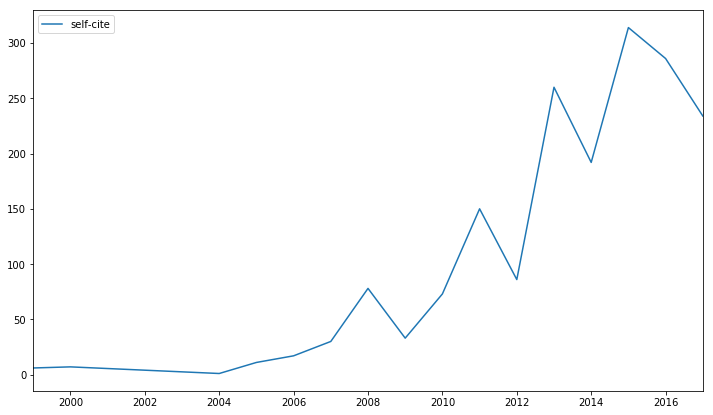

In [9]:
# create 'cite-year-df' by narrowing down 'df' to the top-ten self-citers and setting the index to 'date'
cite_year_df = df[df['author'].isin(top_self)]
cite_year_df = cite_year_df.set_index('date')

# now we can group and sum by year, and plot the results.
cite_year_df = cite_year_df.groupby(cite_year_df.index.year).agg('sum').sort_values('self-cite',ascending=False).sort_index()
cite_year_df.plot(figsize=(12,7))
None

# 3. Can you make a bar plot or a histogram?

Certainly, the data in exercise one is perfect for a bar plot.

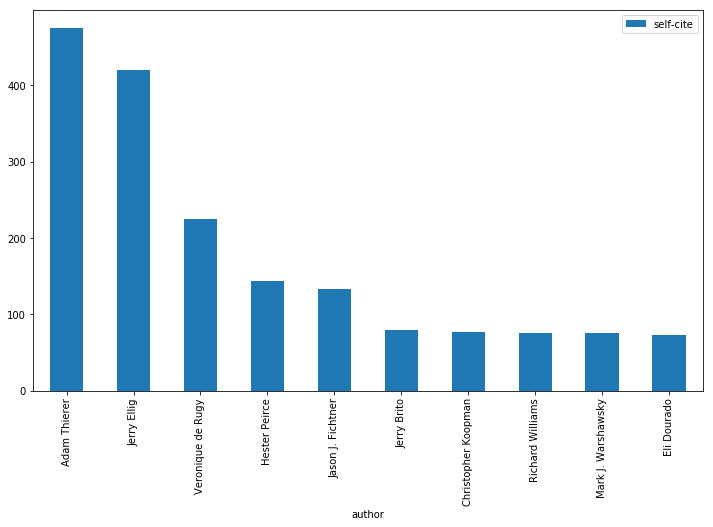

In [10]:
cite_df.plot(kind='bar', figsize=(12,7))
None

# 4. Can you compare two related quantities?

An astute reader may question my methods for poking fun at our scholars on the ground that the top self-citers may also be the top publishers, and their self-citations per paper may actually be reasonably low. And this turns out to be a valid critique! Besides the venerable Adam Thierer, the list of top-ten self-citers changes dramatically when we consider number of papers published.

Interestingly, this list includes mostly contract scholars from outside Mercatus. This may indicate a tendency for contract scholars, who often come from outside universities, to cite themselves as part of the academic rat-race for citations and higher impact scores. Mercatus scholars face different incentives.

In [11]:
# create scpp_df (self-cites-per-paper dataframe), sort values by scpp, and take the top ten offenders.

scpp_df = df.groupby('author').agg(['count','sum'])['self-cite']['sum'] / df.groupby('author').agg(['count','sum'])['filename']['count']
scpp_df = scpp_df.reset_index()
scpp_df.columns = ('author','scpp')
scpp_df = scpp_df.sort_values('scpp',ascending=False).head(10).set_index('author')

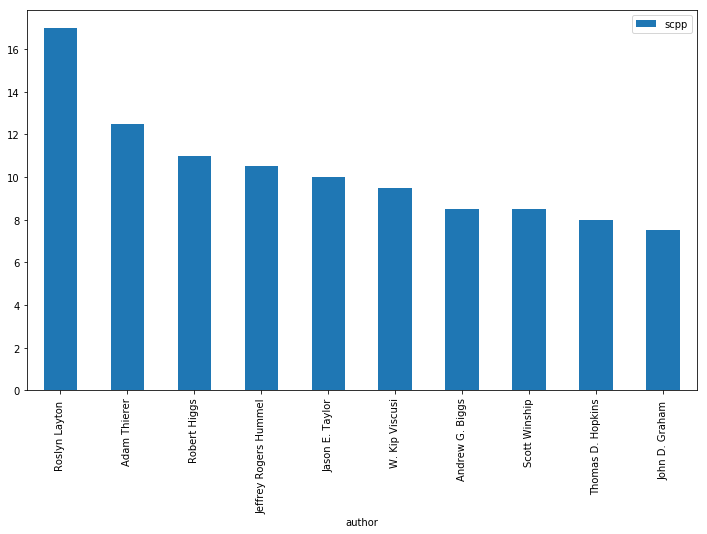

In [12]:
# plot results in a bar graph to see who really likes to agree with themselves.

scpp_df.plot(kind='bar', figsize=(12,7))
None

# 5. Can you make a scatterplot?

Of course! But for the sake of my career, I'm going to move on from self-citations and just plot things Mercatus is proud of, the kinds of things we show donors: total publications.

In [13]:
# create a list of top three publishing authors over the life of Mercatus
top_pub = df.groupby('author').agg('count').fillna(0).sort_values('filename', ascending=False).reset_index().head(3)['author']

# create 'pub_count_df' by narrowing down 'df' to the top-three publishers and setting the index to 'date'
pub_count_df = df[df['author'].isin(top_pub)].set_index('date')

# now we can group and count by year, and show you what we are looking at
pub_count_df = pub_count_df.groupby([pub_count_df.index.year, 'author']).agg('count')['filename'].unstack().reset_index().fillna(0)
pub_count_df


author,index,Jerry Ellig,Robert Graboyes,Veronique de Rugy
0,1999,1.0,0.0,0.0
1,2000,2.0,0.0,0.0
2,2004,1.0,0.0,0.0
3,2005,2.0,0.0,0.0
4,2006,3.0,0.0,0.0
5,2007,3.0,0.0,2.0
6,2008,8.0,0.0,3.0
7,2009,3.0,0.0,3.0
8,2010,5.0,0.0,9.0
9,2011,6.0,0.0,11.0


True


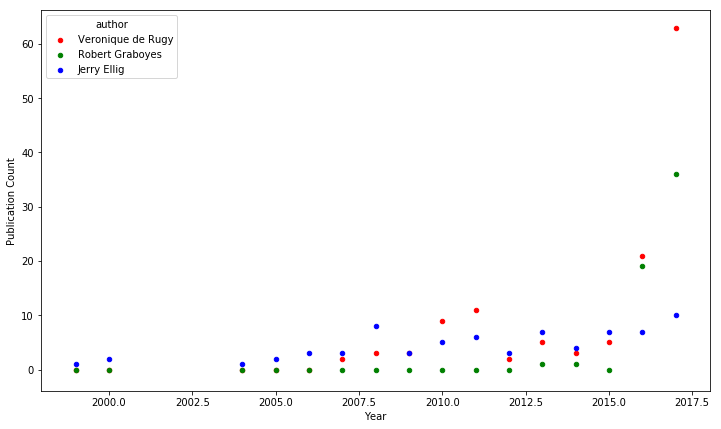

In [14]:
# This part was a bit unpleasant and took some stackexchange research. I'm sure there are prettier ways
# to scatterplot three columns but this is what I ended up with.

ax1 = pub_count_df.plot(kind='scatter', x='index', y='Veronique de Rugy', color='r', label="Veronique de Rugy")    
ax2 = pub_count_df.plot(kind='scatter', x='index', y='Robert Graboyes', color='g', ax=ax1, label='Robert Graboyes')    
ax3 = pub_count_df.plot(kind='scatter', x='index', y='Jerry Ellig', color='b', ax=ax2, label='Jerry Ellig', figsize=(12,7))    

ax3.set_ylabel('Publication Count')
ax3.set_xlabel('Year')

print(ax1 == ax2 == ax3)

# 6. Can you make a time-series plot?

I think we already did that in exercise 2, but I'll do it again for the total publications data. Veronique is having one heck of a year, probably as a result of publishing a large number of columns in response to the rise of Donald Trump.

Bob Graboyes is the real story here - he has been famously low-output for a long time, but something in 2016 and 2017 has him putting pen to paper at an unprecedented rate. Graboyes is a healthcare expert, so I would guess the efforts to repeal the ACA has kept him very busy.

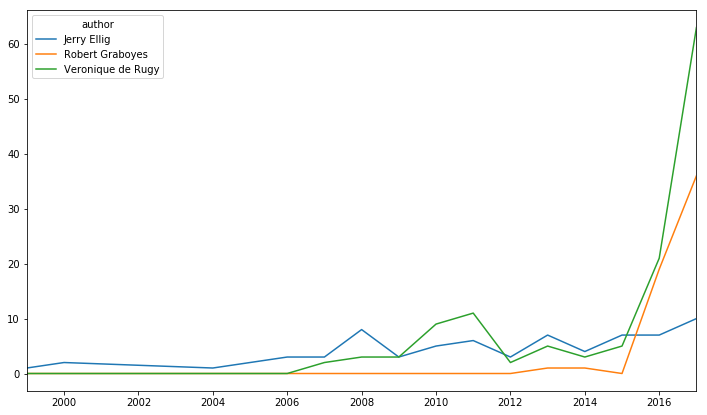

In [15]:
# create 'pub_count_df' by narrowing down 'df' to the top-three publishers and setting the index to 'date'
pub_count_df = df[df['author'].isin(top_pub)].set_index('date')

# now we can group and count by year, and show you what we are looking at
pub_count_df = pub_count_df.groupby([pub_count_df.index.year, 'author']).agg('count')['filename'].unstack().fillna(0)
pub_count_df.plot(figsize=(12,7))
None

## Having made these plots, what are some insights you get from them? 

The 2016 election has been excellent for scholar output, contract scholars love to cite themselves, and Adam Thierer publishes a lot *and* cites himself often.

## Do you see any correlations? Is there a hypothesis you would like to investigate further?

I'm actually kind of curious about self-citations among university department scholars vs. research center scholars (or, as discussed in this notebook, outside contract scholars vs. Mercatus scholars). It seems like Mercatus scholars feel significantly less pressure to inflate their citation counts.

## Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? 

I think the policy editing team could be interested in frivolous self-citations and the increased likelihood amongst outside scholars. If they are fine with it, then using the opportunity to cite oneself in upper-brow policy research output as a selling point for contract scholars may be a good move for our program managers.